In [1]:
import torch

torch.manual_seed(1488)

import tqdm
import numpy as np
# from pytekvel.preprocessing import Decomposer
import joblib
from torch import nn
from utils import Decomposer, TempRWE_Encoder, PrecomputedWaveletEmbeddingDataset, SubBatcher
from utils import get_model_preds_probas_targets, custom_metric_torch_batch, double_metric
from torch.utils.data import DataLoader

from monitoring import Monitor

from plotly import graph_objects as go

dataset_root_path = './dataset'
start_idx = 80*20

In [2]:
class RNNModel(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            # nn.Sigmoid()
        )
    
    # def init_hidden(self, batch_size):
    #     preusdo_x = torch.zeros(batch_size, 1, self.rnn.hidden_size)
    #     hs = self.getinit_hidden()
    #     self.rnn(preusdo_x, hs)

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn.hidden_size)

    def forward(self, x, hidden_state=None):
        
        if hidden_state is None:
            hidden_state = self.init_hidden(x.size(0)).to(device)
        
        out, hidden_state = self.rnn(x, hidden_state)
        out_logits = self.fc(out)
        out_logits = out_logits.squeeze(-1)
        
        return out_logits, hidden_state

In [3]:
encoder = TempRWE_Encoder(maxcurrent=500, wavename="rbio1.3", maxlevel=4, verbosity=0)

try:
    train_embs = joblib.load("./precomp/train_embs-rbio1.3-6-1024-1.joblib")
    print("Captured existing")

except:
    data_train = joblib.load(dataset_root_path + "/train/data-multi-train-fixed.joblib")
    labels_train = joblib.load(dataset_root_path + "/train/labels-multi-train-fixed.joblib")

    data_train = Decomposer(maxcurrent=500).normalize(data_train)
    data_train = np.array(data_train)
    labels_train = np.array(labels_train)

    train_embs = PrecomputedWaveletEmbeddingDataset(data_train, labels_train, encoder, wsize=256, stride=1, start_idx=start_idx)
    print('Train Set')
    print(len(train_embs))
    data, target = train_embs[0]
    print(type(data), type(target))
    print(data.shape, target.shape, '\n')

Captured existing


In [4]:
data, label = train_embs[0]
label.shape

torch.Size([4002])

In [5]:
try:
    test_embs = joblib.load("./precomp/test_embs-rbio1.3-6-1024-1.joblib")
    print("Captured existing")

except:
    data_test = joblib.load(dataset_root_path + "/test/data-multi-test-fixed.joblib")
    labels_test = joblib.load(dataset_root_path + "/test/labels-multi-test-fixed.joblib")

    data_test = Decomposer(maxcurrent=500).normalize(data_test)
    data_test = np.array(data_test)
    labels_test = np.array(labels_test)

    test_embs = PrecomputedWaveletEmbeddingDataset(data_test, labels_test, encoder, wsize=256, stride=1, start_idx=start_idx)
    print('Test Set')
    print(len(test_embs))
    data, target = test_embs[0]
    print(type(data), type(target))
    print(data.shape, target.shape)

Captured existing


In [6]:
loader_train = DataLoader(train_embs, batch_size=32, shuffle=False)
batch = next(iter(loader_train))
batch_data, batch_target = batch
print('Train Batch')
print(batch_data.shape)
print(batch_target.shape)


Train Batch
torch.Size([32, 4002, 26])
torch.Size([32, 4002])


In [7]:
loader_test = DataLoader(test_embs, batch_size=32, shuffle=False)
batch = next(iter(loader_test))
batch_data, batch_target = batch
print('Test Batch')
print(batch_data.shape)
print(batch_target.shape)

Test Batch
torch.Size([32, 4002, 26])
torch.Size([32, 4002])


### SubBacthed Learning of RNN

Here we split each big sequence into several smaller ones of given size. Now for each batch e.g. [32, 4000, 128] we have subbatch of subsequences [10, 32, 400, 128], so each of 10 elements of this tensor is a set of subsequence with corresponding index for each of 32 units in original batch. While running along subbatch (10 elems), RNN initializes its hidden_state using state from previous subbatch: for subbatch 6 it uses hidden_state from subbatch 5. Nevertheless each big batch is independent for RNN, meaning each time it takes new big batch, her memory is initialized from scratch. This is because only subbatches have temporal dependence, not big batches.

In [8]:
subsequence_len = 400

In [15]:
num_epochs = 75
FN_punish = 20.0
proba_threshold = 0.5
learning_rate = 0.15
betas = (0.907, 0.999)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
        print(f"Active GPU: {torch.cuda.get_device_name(device)}")
else:
    print("Now CPU is used")


model = RNNModel(embedding_size=26, hidden_size=64).to(device)
pos_w = torch.tensor([FN_punish], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(weight=pos_w) #punishes for False Negatives
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)


monitor = Monitor()

Active GPU: NVIDIA RTX A5000


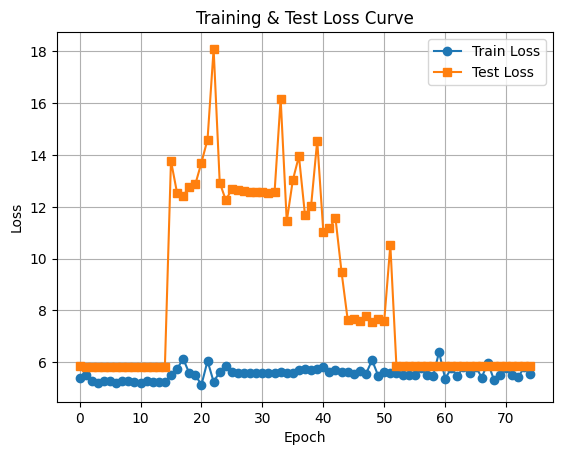

In [16]:
# Train loop for SubBatched learning
for epoch in range(num_epochs):
    print("-"*50)
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    model.train()
    train_loss = 0.0
    train_loss_sub = 0
    train_score = 0.0
    train_score_sub = 0.0
    
    # hidden_state = model.init_hidden(loader_train.batch_size)

    itr_obj = tqdm.tqdm(loader_train, total=len(loader_train), desc='   Training')
    for batch_data, batch_target in itr_obj:

        batch_data, batch_target = batch_data.to(device), batch_target.to(device)
        
        hidden_state = model.init_hidden(batch_data.size(0)).to(device)

        subbatch_data, subbatch_target = SubBatcher(subsequence_len)(batch_data, batch_target)

        for subseq, sublabel in zip(subbatch_data, subbatch_target):
            # Forward pass
            out_logits, hidden_state = model(subseq, hidden_state)    #logits
            loss = criterion(out_logits, sublabel.float())            #as logits

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_sub += loss.item()
            
            probas = torch.sigmoid(out_logits)
            preds_binary = probas >= proba_threshold

            # Saves hidden state, subseqs in subbatch are time-dependent
            hidden_state = hidden_state.detach()        #deactivate compute-graph
        
            # score = custom_metric_torch_batch(y_true=sublabel, y_pred=preds_binary)
            # train_score_sub += score.mean()

        train_loss_sub /= len(subbatch_data)    #avg over long sequence (for batch)
        train_score_sub /= len(subbatch_data)   #avg over long sequence (for batch)

        train_loss += train_loss_sub
        train_score += train_score_sub
        # print(f"Train Loss : {train_loss:.4f}")
    
    train_loss /= len(loader_train)         #avg over big batches (for epoch)
    train_score /= len(loader_train)        #avg over big batches (for epoch)

    
    model.eval()
    test_loss = 0.0
    test_score = 0.0

    with torch.no_grad():
        itr_obj = tqdm.tqdm(loader_test, total=len(loader_test), desc=' Evaluation')
        for batch_data, batch_target in itr_obj:
            batch_data, batch_target = batch_data.to(device), batch_target.to(device)
            out_logits, _ = model(batch_data)
            loss = criterion(out_logits, batch_target.float())
            test_loss += loss.item()
            probas = torch.sigmoid(out_logits)
            preds_binary = probas >= proba_threshold

            
            score_mean = custom_metric_torch_batch(y_true=batch_target, y_pred=preds_binary).mean()
            # # print(f"    AVG Train Score (over {len(batch_data)} units): {score_mean * 100:.4f}%")
            # test_score += score_mean
    
    
    

    test_loss /= len(loader_test)
    # test_score /= len(loader_test)

    monitor.add_train_loss(train_loss)
    monitor.add_test_loss(test_loss)
    monitor.show()
    # print(f"Train Loss : {train_loss:.4f}, Test Loss : {test_loss:.4f}")
    # print(f"Train Score: {train_score}, Test Score: {test_score}")
    # print("-"*50)

In [17]:
joblib.dump(model, "trwe-rnn-1024-subbatch-1000.joblib")

['trwe-rnn-1024-subbatch-1000.joblib']

In [34]:
proba_tr = 0.05

preds, probas, targets = get_model_preds_probas_targets(model, loader_test, proba_threshold=proba_tr, device=device)
preds = torch.zeros_like(targets, dtype=torch.float32)
print(preds.shape)
print(probas.shape)
print(targets.shape)

test_scores = custom_metric_torch_batch(y_pred=probas > proba_tr, y_true=targets)
print(test_scores.shape)

print(f"Score (>{proba_tr}): {test_scores.mean()*100:.4f}%")
# fig = go.Figure(data=[
#         go.Scatter(y=mf.cpu(), name='Unit Scores'),
    
#     ])

# # Add basic styling
# fig.update_layout(
#     title='',
#     xaxis_title='Index',
#     yaxis_title='Score'
# )

# fig.show()

 Evaluation: 100%|██████████| 62/62 [00:00<00:00, 332.65it/s]

torch.Size([1971, 4002])
torch.Size([1971, 4002])
torch.Size([1971, 4002])
torch.Size([1971])
Score (>0.05): 8.3021%


In [35]:
probas.max()

tensor(0.0587, device='cuda:0')

In [36]:
data_test = joblib.load(dataset_root_path + "/test/data-multi-test-fixed.joblib")
labels_test = joblib.load(dataset_root_path + "/test/labels-multi-test-fixed.joblib")

data_test = Decomposer(maxcurrent=500).normalize(data_test)
data_test = np.array(data_test)

unit_idx = 1967
embedding, labels = test_embs[unit_idx]
data = data_test[unit_idx, start_idx:]

model.eval()
with torch.no_grad():
    print(data.shape)
    print(embedding.shape)
    logits, _ = model(embedding.unsqueeze(0).to(device))
    predict = torch.sigmoid(logits)
    print(predict.shape)

    fig = go.Figure(data=[
        go.Scatter(y=data, name='Time-Series'),
        go.Scatter(y=labels, name='Binary Labels'),
        go.Scatter(y=predict.cpu().reshape(-1), name='probas'),
        go.Scatter(y=(predict.cpu().reshape(-1) > proba_tr) * 1.2, name='preds')
    ])

    # Add basic styling
    fig.update_layout(
        title='',
        xaxis_title='Index',
        yaxis_title='Values'
    )

    fig.show()

(4001,)
torch.Size([4002, 26])
torch.Size([1, 4002])
